# 수화 이미지 CNN으로 분류하기

병준 part

0~9 숫자에 대응하는 수화 데이터 투입

숫자 사인 한 종류 당 1500장 이미지

한 이미지 당 50x50 픽셀

# CNN 최종 버전

라이브러리 가져오기

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import random
from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from keras.preprocessing.image import ImageDataGenerator

구글 드라이브에서 데이터셋 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/rawimage.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


라벨링

In [ ]:
# dir_ = Path('/content/rawimage')
# filepaths = list(dir_.glob(r'**/*.jpg'))
# def proc_img(filepath):
#     """
#    		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
#     """

#     labels = [str(filepath[i]).split("/")[-2] \
#               for i in range(len(filepath))]
rand_num_list=rand_num_list = [random.sample([num for num in range(1,1501)], 345) for _ in range(0,10,1) ]
filepaths = []
for i in range(0,10,1):
    for j in range(0,300,1):
        filepaths.append(f"/content/rawimage/{i}/{rand_num_list[i][j]}.jpg")

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/rawimage/1/1147.jpg,1
1,/content/rawimage/3/1255.jpg,3
2,/content/rawimage/5/22.jpg,5
3,/content/rawimage/9/1069.jpg,9
4,/content/rawimage/9/246.jpg,9


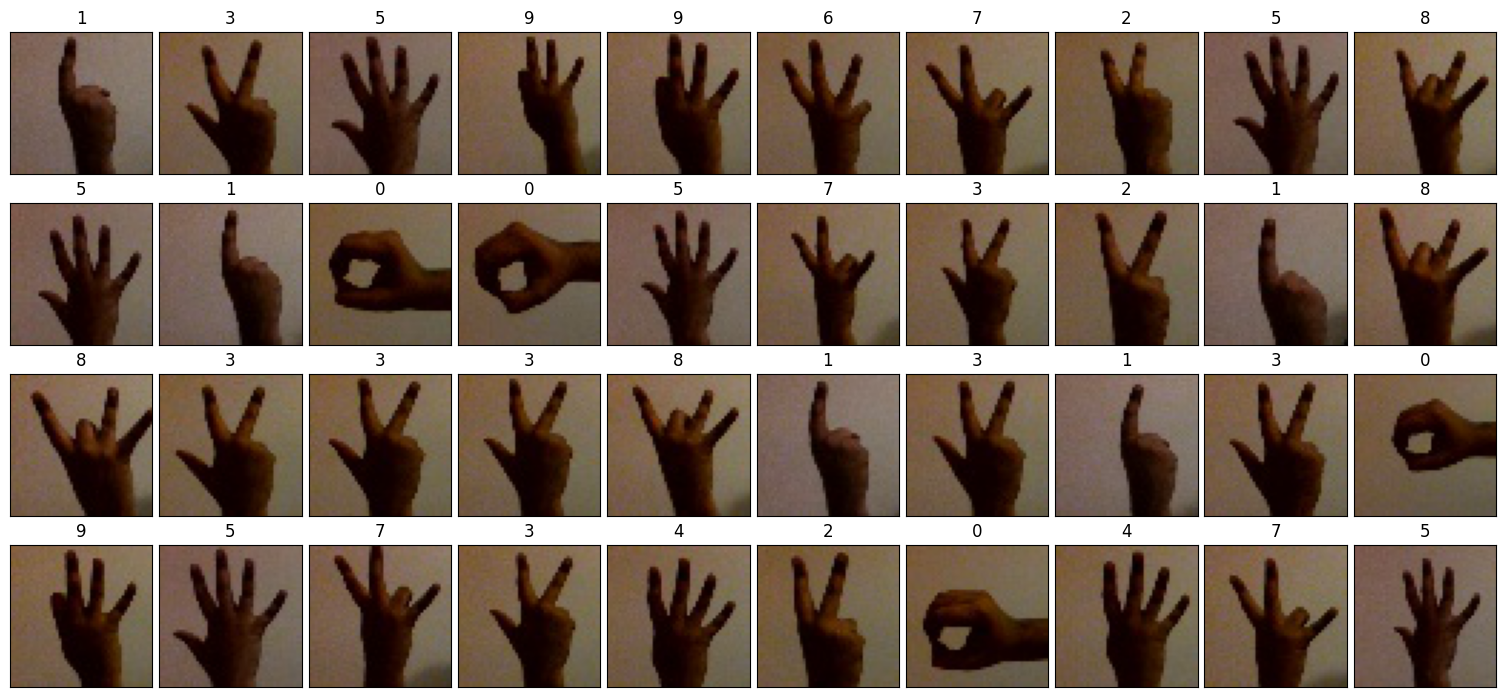

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

이미지를 train, test로 분류

In [ ]:
# Training/test split

train_df,test_df = train_test_split(df, test_size=0.15,random_state=0)
train_df.shape,test_df.shape

((2550, 2), (450, 2))

데이터 전처리(학습시키기 좋은 데이터 만들기)

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.18)
test_datagen = ImageDataGenerator(rescale=1.0/255,)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50, 50), #사이즈를 (150,150)에서 (50,50)으로 바꿈
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        subset='training',
)

val_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50, 50),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        subset='validation'
    )

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50,50),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

Found 2091 validated image filenames belonging to 10 classes.
Found 459 validated image filenames belonging to 10 classes.
Found 450 validated image filenames belonging to 10 classes.


CNN 모델 구조 정의

In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=[50, 50, 3])) #사이즈를 (150,150)에서 (50,50)으로 바꿈

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax')) #10개로 분류하므로 units=10

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1936)              0         
                                                                 
 dense (Dense)               (None, 64)                1

학습

In [ ]:
history = cnn.fit(x = train_generator, validation_data = val_generator, epochs = 10)

Epoch 1/10
66/66 [==============================] - 7s 69ms/step - loss: 1.4475 - accuracy: 0.6265 - val_loss: 0.3845 - val_accuracy: 0.9041
Epoch 2/10
66/66 [==============================] - 4s 63ms/step - loss: 0.1394 - accuracy: 0.9737 - val_loss: 0.0637 - val_accuracy: 0.9891
Epoch 3/10
66/66 [==============================] - 7s 104ms/step - loss: 0.0362 - accuracy: 0.9952 - val_loss: 0.0339 - val_accuracy: 0.9956
Epoch 4/10
66/66 [==============================] - 4s 63ms/step - loss: 0.0137 - accuracy: 0.9986 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 5/10
66/66 [==============================] - 4s 65ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 6/10
66/66 [==============================] - 6s 98ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9978
Epoch 7/10
66/66 [==============================] - 4s 66ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 8/10
6

학습 결과 보여주기(accuracy, loss)

Text(0.5, 1.0, 'Training and validation loss')

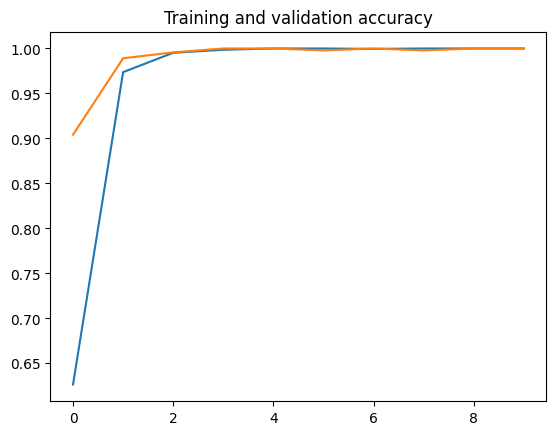

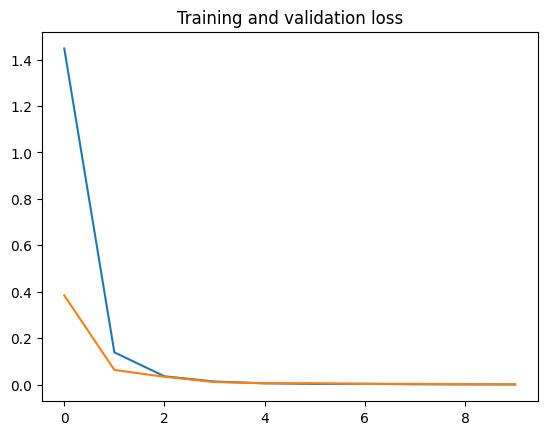

In [ ]:
%matplotlib inline

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

test 데이터셋을 이용한 test loss, test accuracy 확인

In [ ]:
test_loss, test_accuracy = cnn.evaluate(test_generator, batch_size=32)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 0s 27ms/step - loss: 0.0132 - accuracy: 0.9978
Test Loss:     0.01319491770118475
Test Accuracy: 0.9977777600288391


샘플 데이터셋을 학습된 모델에 넣기

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 1483.jpg to 1483.jpg


1/1 [==============================] - 0s 354ms/step
## prediction : 100.00%
Number 7


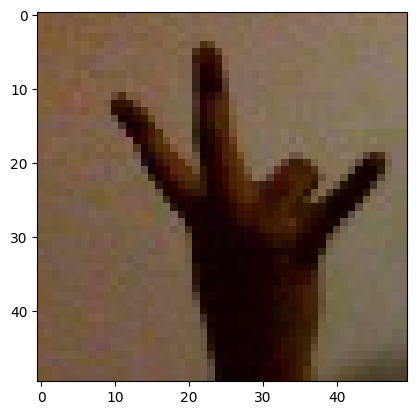

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/1483.jpg"

test_image = image.load_img(img_path, target_size = (50,50))
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
#test_image = preprocess_input(test_image)
prediction = cnn.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
print(f"## prediction : {(df.iloc[0]['pred'])* 100:.2f}%")

if prediction[0][0] == 1:
  print('Number 0')
elif prediction[0][1] == 1:
  print('Number 1')
elif prediction[0][2] == 1:
  print('Number 2')
elif prediction[0][3] == 1:
  print('Number 3')
elif prediction[0][4] == 1:
  print('Number 4')
elif prediction[0][5] == 1:
  print('Number 5')
elif prediction[0][6] == 1:
  print('Number 6')
elif prediction[0][7] == 1:
  print('Number 7')
elif prediction[0][8] == 1:
  print('Number 8')
elif prediction[0][9] == 1:
  print('Number 9')

bruteforce 숫자별 정확도 구하기(상협 ver)

In [ ]:
from tensorflow.keras.preprocessing import image

test_result =[]


for i in range(0,10,1):
    correct_count = 0
    for j in range(300,345,1):
        img_path = (f"/content/rawimage/{i}/{rand_num_list[i][j]}.jpg")

        test_image = image.load_img(img_path, target_size = (50,50))
        test_image = image.img_to_array(test_image)

        test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
        #test_image = preprocess_input(test_image)
        prediction = cnn.predict(test_image)

        df = pd.DataFrame({'pred':prediction[0]})
        df = df.sort_values(by='pred', ascending=False, na_position='first')
        print(f"#{i} prediction : {(df.iloc[0]['pred'])* 100:.2f}%")
        if prediction[0][0] == 1:
          print('Number 0')
        elif prediction[0][1] == 1:
          print('Number 1')
        elif prediction[0][2] == 1:
          print('Number 2')
        elif prediction[0][3] == 1:
          print('Number 3')
        elif prediction[0][4] == 1:
          print('Number 4')
        elif prediction[0][5] == 1:
          print('Number 5')
        elif prediction[0][6] == 1:
          print('Number 6')
        elif prediction[0][7] == 1:
          print('Number 7')
        elif prediction[0][8] == 1:
          print('Number 8')
        elif prediction[0][9] == 1:
          print('Number 9')
        if prediction[0][i] == 1:
            print('Correct')
            correct_count+=1

    print("==================================================================================================")
    print(f"Number{i}= {correct_count} correct")
    test_result.append(correct_count)
    print("==================================================================================================")

print("========================================")
for i in range(0,10,1):
    print(f"num of correct: #{i} : {test_result[i]}, accuracy: {round((test_result[i]/0.45),2)}%")
print("========================================")

1/1 [==============================] - 0s 62ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 83ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 38ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 32ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 56ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 97ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 33ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 124ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 57ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 51ms/step
#0 prediction : 100.00%
Number 0
Correct
1/1 [==============================] - 0s 29ms/step
#0 prediction : 1

# 추가) 수화 데이터셋 대신 얼굴 표정 데이터셋

사람의 얼굴 표정 이미지가 담긴 데이터셋 사용

48x48 흑백 png 사진 24176장

angry(3995), happy(7215), neutral(4965), sad(4830), surprised(3171)의 항목으로 구성되어 있음

라이브러리 가져오기

In [3]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import random
from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from keras.preprocessing.image import ImageDataGenerator

구글 드라이브에서 데이터셋 가져오기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/emotions3.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

라벨링

In [6]:
dir_ = Path('/content/emotions')
filepaths = list(dir_.glob(r'**/*.png'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='img_path').astype(str)
    labels = pd.Series(labels, name='label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,img_path,label
0,/content/emotions/surprised/im649.png,surprised
1,/content/emotions/sad/im154.png,sad
2,/content/emotions/sad/im3142.png,sad
3,/content/emotions/happy/im5702.png,happy
4,/content/emotions/angry/im3952.png,angry


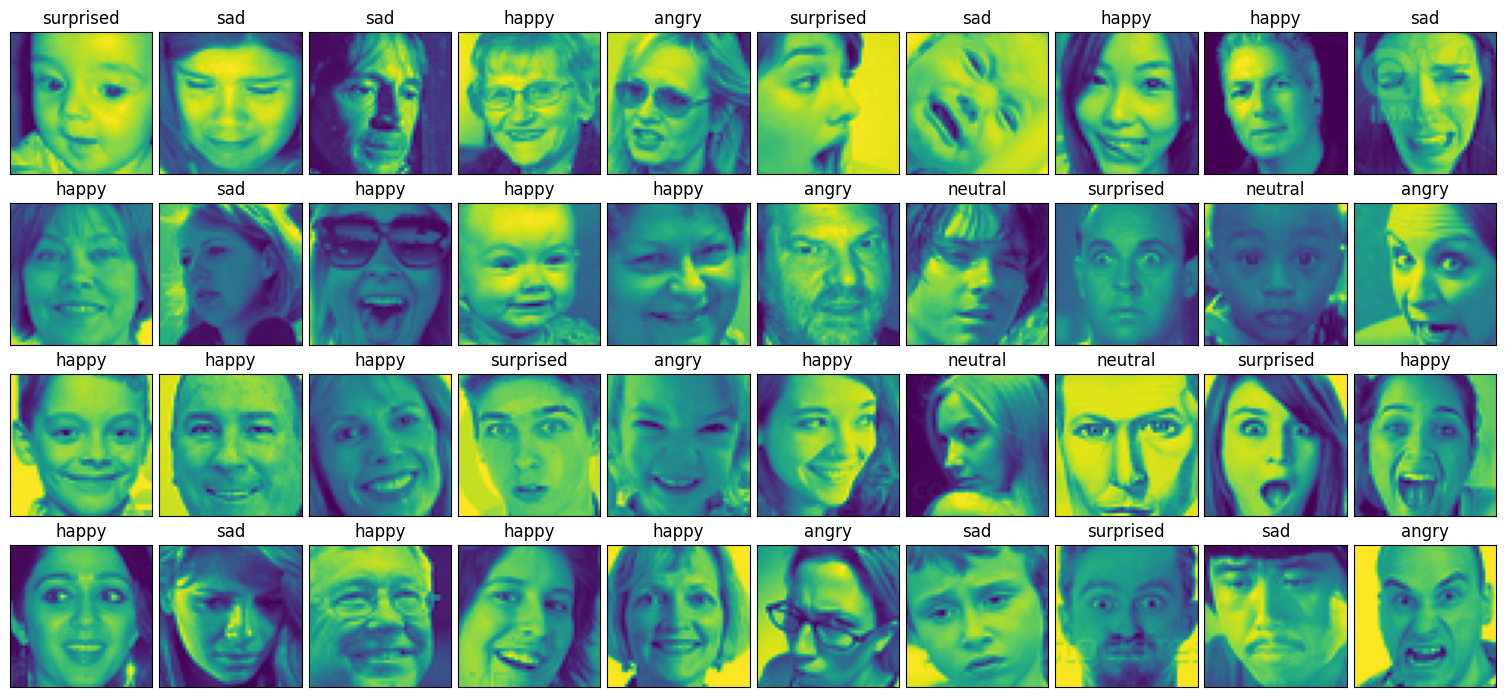

In [7]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.img_path[i]))
    ax.set_title(df.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

이미지를 train, test로 분류

In [8]:
# Training/test split

#print(type(df.label[i]))
train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((19340, 2), (4836, 2))

In [9]:
print(train_df)

                                     img_path      label
16136    /content/emotions/neutral/im1703.png    neutral
15643        /content/emotions/sad/im2671.png        sad
448        /content/emotions/happy/im2357.png      happy
7241     /content/emotions/neutral/im3738.png    neutral
4866   /content/emotions/surprised/im3085.png  surprised
...                                       ...        ...
13123          /content/emotions/sad/im48.png        sad
19648    /content/emotions/neutral/im2237.png    neutral
9845     /content/emotions/neutral/im2077.png    neutral
10799        /content/emotions/sad/im3673.png        sad
2732     /content/emotions/neutral/im4076.png    neutral

[19340 rows x 2 columns]


In [10]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.label.unique())}\n')
print(f'Labels: {df.label.unique()}')

Number of pictures: 24176

Number of different labels: 5

Labels: ['surprised' 'sad' 'happy' 'angry' 'neutral']


데이터 전처리(학습시키기 좋은 데이터 만들기)

In [11]:
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.25)
test_datagen = ImageDataGenerator(rescale=1.0/255,)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='img_path',
        y_col='label',
        target_size=(48, 48),
        class_mode='categorical',
        batch_size=32,
        subset='training',
)

val_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='img_path',
        y_col='label',
        target_size=(48, 48),
        class_mode='categorical',
        batch_size=32,
        subset='validation'
    )

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='img_path',
        y_col='label',
        target_size=(48,48),
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

Found 14505 validated image filenames belonging to 5 classes.
Found 4835 validated image filenames belonging to 5 classes.
Found 4836 validated image filenames belonging to 5 classes.


CNN 모델 구조 정의

기존의 구조를 그대로 사용

In [14]:
# Initialising the CNN
cnn1 = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn1.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=[48, 48, 3]))

# Step 2 - Pooling
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn1.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn1.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Step 5 - Output Layer
cnn1.add(tf.keras.layers.Dense(units=5, activation='softmax'))

# Compiling the CNN
cnn1.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 8)         224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [15]:
history = cnn1.fit(x = train_generator, validation_data = val_generator, epochs = 19)

Epoch 1/19
454/454 [==============================] - 32s 67ms/step - loss: 1.4380 - accuracy: 0.3876 - val_loss: 1.3225 - val_accuracy: 0.4676
Epoch 2/19
454/454 [==============================] - 31s 68ms/step - loss: 1.2745 - accuracy: 0.4800 - val_loss: 1.2455 - val_accuracy: 0.5022
Epoch 3/19
454/454 [==============================] - 33s 72ms/step - loss: 1.1861 - accuracy: 0.5213 - val_loss: 1.2024 - val_accuracy: 0.5148
Epoch 4/19
454/454 [==============================] - 32s 70ms/step - loss: 1.1211 - accuracy: 0.5496 - val_loss: 1.1971 - val_accuracy: 0.5156
Epoch 5/19
454/454 [==============================] - 32s 71ms/step - loss: 1.0675 - accuracy: 0.5779 - val_loss: 1.1565 - val_accuracy: 0.5272
Epoch 6/19
454/454 [==============================] - 31s 67ms/step - loss: 1.0093 - accuracy: 0.6014 - val_loss: 1.1501 - val_accuracy: 0.5311
Epoch 7/19
454/454 [==============================] - 30s 66ms/step - loss: 0.9563 - accuracy: 0.6292 - val_loss: 1.1607 - val_accuracy:

Text(0.5, 1.0, 'Training and validation loss')

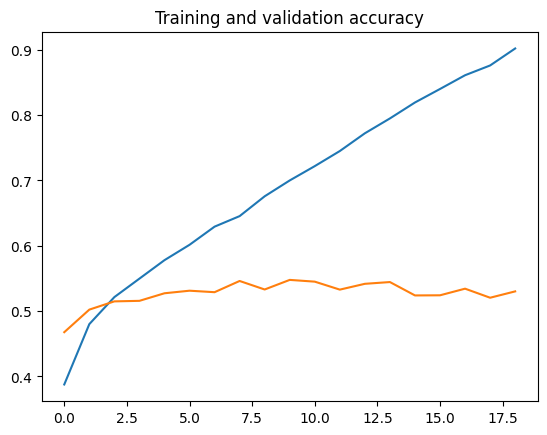

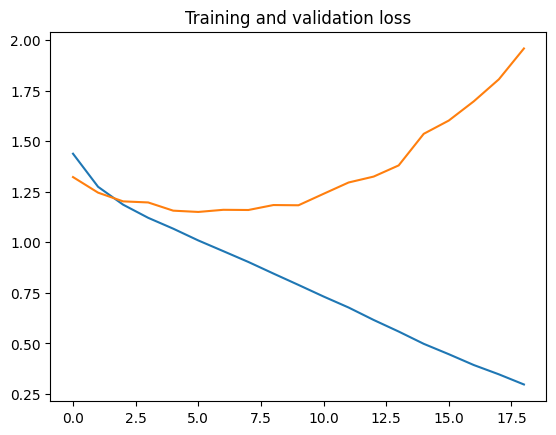

In [16]:
%matplotlib inline

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [18]:
test_loss, test_accuracy = cnn1.evaluate(test_generator, batch_size=32)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

152/152 [==============================] - 6s 35ms/step - loss: 2.0372 - accuracy: 0.5316
Test Loss:     2.037167549133301
Test Accuracy: 0.5316377282142639


CNN 모델 구조 정의

기존 구조의 업그레이드 버전

필터 크기, Batchnormalization, Dropout 등 수정 및 추가

In [10]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Activation

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, activation='relu', input_shape=[48, 48, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(BatchNormalization())

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(BatchNormalization())

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(BatchNormalization())

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn.add(Dropout(0.5))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))
# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

In [12]:
history = cnn.fit(x = train_generator, validation_data = val_generator, epochs = 19)

Epoch 1/19
454/454 [==============================] - 219s 482ms/step - loss: 1.5265 - accuracy: 0.3553 - val_loss: 1.4188 - val_accuracy: 0.4068
Epoch 2/19
454/454 [==============================] - 215s 473ms/step - loss: 1.3451 - accuracy: 0.4445 - val_loss: 1.4192 - val_accuracy: 0.4449
Epoch 3/19
454/454 [==============================] - 180s 397ms/step - loss: 1.2336 - accuracy: 0.4942 - val_loss: 1.2872 - val_accuracy: 0.4647
Epoch 4/19
454/454 [==============================] - 181s 400ms/step - loss: 1.1501 - accuracy: 0.5276 - val_loss: 1.3543 - val_accuracy: 0.4517
Epoch 5/19
454/454 [==============================] - 190s 419ms/step - loss: 1.0973 - accuracy: 0.5550 - val_loss: 1.2524 - val_accuracy: 0.4821
Epoch 6/19
454/454 [==============================] - 185s 409ms/step - loss: 1.0477 - accuracy: 0.5778 - val_loss: 1.2228 - val_accuracy: 0.4972
Epoch 7/19
454/454 [==============================] - 186s 410ms/step - loss: 0.9915 - accuracy: 0.6048 - val_loss: 1.1604 -

학습 결과 보여주기(accuracy, loss)

Text(0.5, 1.0, 'Training and validation loss')

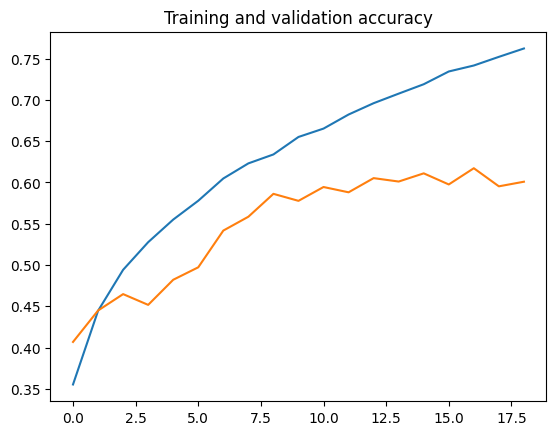

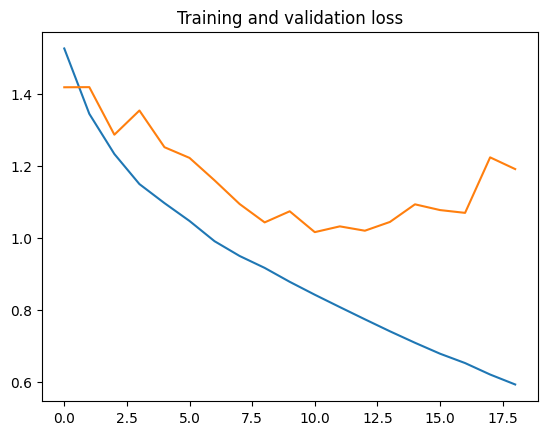

In [13]:
%matplotlib inline

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

test 데이터셋을 이용한 test loss, test accuracy 확인

In [14]:
test_loss, test_accuracy = cnn.evaluate(test_generator, batch_size=32)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

152/152 [==============================] - 15s 100ms/step - loss: 1.2234 - accuracy: 0.5999
Test Loss:     1.223421335220337
Test Accuracy: 0.5998759269714355


샘플 데이터셋을 학습된 모델에 넣기

In [15]:
from google.colab import files
uploaded = files.upload()

Saving im421.png to im421.png


1/1 [==============================] - 0s 315ms/step
## prediction : 100.00%
SAD


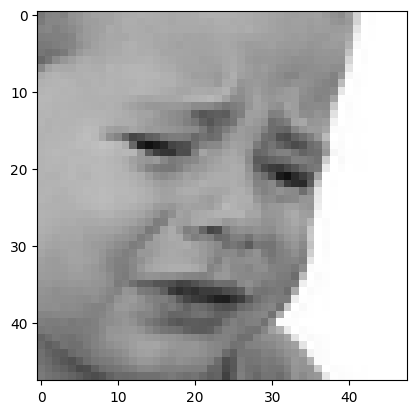

In [16]:
from tensorflow.keras.preprocessing import image

img_path = "/content/im421.png"

test_image = image.load_img(img_path, target_size = (48,48))
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
#test_image = preprocess_input(test_image)
prediction = cnn.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
print(f"## prediction : {(df.iloc[0]['pred'])* 100:.2f}%")

if prediction[0][0] == 1:
  print('ANGRY')
elif prediction[0][1] == 1:
  print('HAPPY')
elif prediction[0][2] == 1:
  print('NEUTRAL')
elif prediction[0][3] == 1:
  print('SAD')
elif prediction[0][4] == 1:
  print('SURPRISED')

# ResNet 사용

ResNet 모델 정의

ResNet의 주요 아이디어는 skip connection

In [17]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

new_model = ResNet50(weights='imagenet', input_tensor=Input(shape=(48, 48, 3)))

x = new_model.get_layer('avg_pool').output

oputs = layers.Dense(5, activation='softmax')(x)

res_model = Model(inputs=new_model.input, outputs=oputs)
res_model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                           

In [18]:
from tensorflow.keras.optimizers import Adam

res_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
history = res_model.fit(
      train_generator,
      epochs=8, # 학습 시간이 너무 오래 걸리는 관계로, 8로 설정
      validation_data=val_generator)

Epoch 1/8
454/454 [==============================] - 1989s 4s/step - loss: 1.0799 - accuracy: 0.5769 - val_loss: 1.5429 - val_accuracy: 0.4374
Epoch 2/8
454/454 [==============================] - 1935s 4s/step - loss: 0.9291 - accuracy: 0.6341 - val_loss: 1.2138 - val_accuracy: 0.5390
Epoch 3/8
454/454 [==============================] - 1877s 4s/step - loss: 0.8466 - accuracy: 0.6718 - val_loss: 1.0993 - val_accuracy: 0.5752
Epoch 4/8
454/454 [==============================] - 1944s 4s/step - loss: 0.8725 - accuracy: 0.6674 - val_loss: 1.0136 - val_accuracy: 0.6037
Epoch 5/8
454/454 [==============================] - 1948s 4s/step - loss: 0.7073 - accuracy: 0.7324 - val_loss: 1.1036 - val_accuracy: 0.5948
Epoch 6/8
454/454 [==============================] - 2078s 5s/step - loss: 0.6541 - accuracy: 0.7544 - val_loss: 1.2100 - val_accuracy: 0.5388
Epoch 7/8
454/454 [==============================] - 1897s 4s/step - loss: 0.5878 - accuracy: 0.7760 - val_loss: 1.2103 - val_accuracy: 0.5874

학습 결과

Text(0.5, 1.0, 'Training and validation loss')

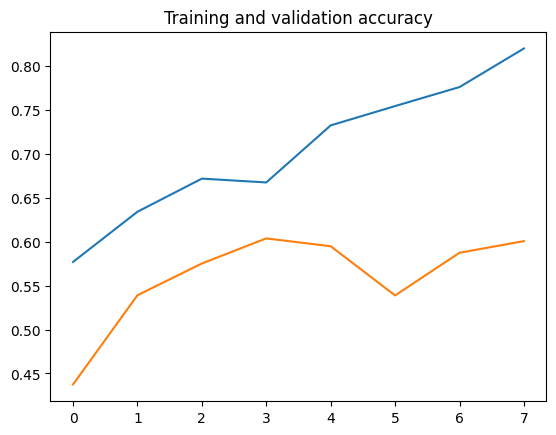

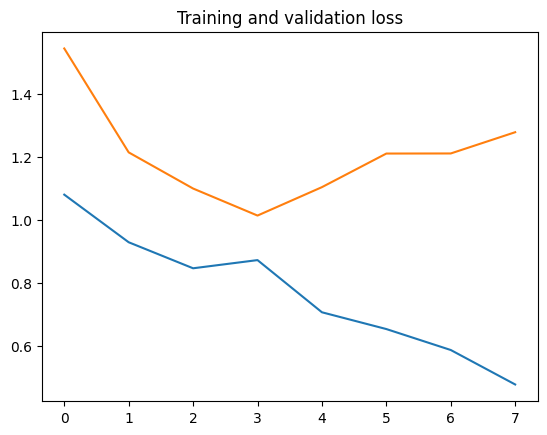

In [21]:
%matplotlib inline

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')